## Imports Libraries


In [1]:
import os
import json
from collections import Counter
import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

## Building the Vocabulary

- we use spacy as a nlp library for efficient tokenization
- word freqencies is taken into account because words that appear very infrequently in the corpus are often typos, rare terms, or irrelevant details. Including these words in the vocabulary can introduce noise and make the model unnecessarily complex.


In [2]:
class Vocabulary:
    # tokenizer
    spacy_eng = spacy.load("en_core_web_sm")

    def __init__(self, freq_threshold):
        # setting the pre-reserved tokens int to string tokens
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}

        # string to int tokens
        # its reverse dict self.itos
        self.stoi = {v: k for k, v in self.itos.items()}

        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in Vocabulary.spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()

        # staring index 4
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                # add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        """For each word in the text corresponding index token for that word form the vocab built as list"""
        tokenized_text = self.tokenize(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

## Dataset and Dataloader


In [3]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, caption_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform

        # Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir, img_name)
        img = Image.open(img_location).convert("RGB")

        # apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)

        # numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)


def get_data_loader(dataset, vocab, batch_size, shuffle=False, num_workers=1):
    pad_idx = vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx, batch_first=True)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )
    return data_loader

In [4]:
class CapsCollate:
    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(
            targets, batch_first=self.batch_first, padding_value=self.pad_idx
        )
        return imgs, targets

In [5]:
BASE_DIRECTORY = "../input/flickr8k"

### Helper functions to plot the Tensor image


In [6]:
def read_image(path):
    return Image.open(path)


def show_image(img, title=None):
    """Imshow for Tensor."""

    # unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))

    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Split Dataset to Train, Val and Test


In [18]:
BATCH_SIZE = 32
NUM_WORKER = 4

train_transforms = T.Compose(
    [
        T.Resize((256, 256)),
        T.RandomCrop((224, 224)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=15),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transforms = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


# testing the dataset class
dataset = FlickrDataset(
    root_dir=BASE_DIRECTORY + "/Images",
    caption_file=BASE_DIRECTORY + "/captions.txt",
    transform=transforms,
)


train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [30000, 5000, 5455]
)

# writing the dataloader
train_dataloader = get_data_loader(
    dataset=train_dataset,
    vocab=dataset.vocab,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
)
val_dataloader = get_data_loader(
    dataset=val_dataset,
    vocab=dataset.vocab,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
)

test_dataloader = get_data_loader(
    dataset=test_dataset,
    vocab=dataset.vocab,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
)


vocab_size = len(dataset.vocab)
print(vocab_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

2994


device(type='cuda', index=0)

## Defining the Model Architecture


### CNN Encoder

Resnet is used for **Feature Extraction** with freezing weights (Transfer Learning)


In [8]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.resnet(images)
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, features.size(-1))
        return features

### Attention Mechanism


In [9]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()

        self.attention_dim = attention_dim

        self.W = nn.Linear(decoder_dim, attention_dim)
        self.U = nn.Linear(encoder_dim, attention_dim)

        self.A = nn.Linear(attention_dim, 1)

    def forward(self, features, hidden_state):
        u_hs = self.U(features)
        w_ah = self.W(hidden_state)

        combined_states = torch.tanh(
            u_hs + w_ah.unsqueeze(1)
        )  # (batch_size,num_layers,attemtion_dim)

        attention_scores = self.A(combined_states)  # (batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)  # (batch_size,num_layers)

        alpha = F.softmax(attention_scores, dim=1)  # (batch_size,num_layers)

        attention_weights = features * alpha.unsqueeze(
            2
        )  # (batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)  # (batch_size,num_layers)

        return alpha, attention_weights

### RNN Decoder


In [10]:
# Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(
        self,
        embed_size,
        vocab_size,
        attention_dim,
        encoder_dim,
        decoder_dim,
        drop_prob=0.3,
    ):
        super().__init__()

        # save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)

        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):

        # vectorize the caption
        embeds = self.embedding(captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        # get the seq length to iterate
        seq_length = len(captions[0]) - 1  # Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)

        for s in range(seq_length):
            alpha, context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))

            output = self.fcn(self.drop(h))

            preds[:, s] = output
            alphas[:, s] = alpha

        return preds, alphas

    def generate_caption(self, features, max_len=20, vocab=None):
        # Inference part
        # Given the image features generate the captions

        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        alphas = []

        # starting input
        word = torch.tensor(vocab.stoi["<SOS>"]).view(1, -1).to(device)
        embeds = self.embedding(word)

        captions = []

        for i in range(max_len):
            alpha, context = self.attention(features, h)

            # store the apla score
            alphas.append(alpha.cpu().detach().numpy())

            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)

            # select the word with most val
            predicted_word_idx = output.argmax(dim=1)

            # save the generated word
            captions.append(predicted_word_idx.item())

            # end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            # send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        # covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions], alphas

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

### The Model (Encoder Decoder)


In [11]:
class EncoderDecoder(nn.Module):
    def __init__(
        self,
        embed_size,
        vocab_size,
        attention_dim,
        encoder_dim,
        decoder_dim,
        drop_prob=0.3,
    ):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size=len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [12]:
embed_size = 300
vocab_size = len(dataset.vocab)
attention_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 3e-4

## Initializing The Model

- Criterion: **Cross Entropy Loss**
- Optimizer: **Adam**


In [ ]:
model = EncoderDecoder(
    embed_size=300,
    vocab_size=len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Saving Model Checkpoints


In [14]:
def save_checkpoint(state, filename="/kaggle/working/checkpoint.pth.tar"):
    torch.save(state, filename)


def load_checkpoint(model, optimizer, filename="/kaggle/working/checkpoint.pth.tar"):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]

    return model, optimizer, epoch, loss


def save_epoch_metrics(epoch_metrics_dict, filename):
    with open(filename, "w") as f:
        json.dump(epoch_metrics_dict, f)


def load_epoch_metrics(filename):
    with open(filename, "r") as f:
        epoch_metrics_dict = json.load(f)
    return epoch_metrics_dict

In [15]:
epoch_metrics_dict = {}


def reverse_process_caption(caption):
    ls = [dataset.vocab.itos[idx.item()] for idx in caption]

    ls = [word for word in ls if word not in ["<PAD>", "<SOS>"]]
    return " ".join(ls)

## Training and Evaluating Model on validation set with Hyperparameter Tuning


In [17]:
resume_training = False
start_epoch = 1
if resume_training:
    start_epoch, best_loss = load_checkpoint("/kaggle/working/checkpoint.pth.tar")
    loaded_dict = load_epoch_metrics("/kaggle/working/epoch_metrics.json")
num_epochs = 25
print_every = 938

for epoch in range(start_epoch, num_epochs + 1):
    progress_bar = tqdm(
        enumerate(iter(train_dataloader)), total=len(train_dataloader), leave=False
    )
    for idx, (image, captions) in progress_bar:
        image, captions = image.to(device), captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs, attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        # Backward pass.
        loss.backward()
        if epoch not in epoch_metrics_dict:
            epoch_metrics_dict[epoch] = {}
        if (idx + 1) % print_every == 0:
            epoch_metrics_dict[epoch]["train_loss"] = loss.item()

        # Update the parameters in the optimizer.
        optimizer.step()
        progress_bar.set_description(f"Epoch: {epoch} Loss: {loss.item():.5f}")

    progress_bar.close()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    all_references = []
    all_hypotheses = []
    with torch.no_grad():  # Disable gradient computation
        for idxx, (image, captions) in enumerate(val_dataloader):
            image, captions = image.to(device), captions.to(device)
            for caption in captions:
                all_references.append(reverse_process_caption(caption).split())
            outputs, attentions = model(image, captions)
            targets = captions[:, 1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            val_loss += loss.item()
            for i in range(image.shape[0]):
                features = model.encoder(image[i : i + 1].to(device))
                caps, alphas = model.decoder.generate_caption(
                    features, vocab=dataset.vocab
                )
                caption = " ".join(caps)
                all_hypotheses.append(caption.split())
        val_loss /= len(val_dataloader)
        epoch_metrics_dict[epoch]["val_loss"] = val_loss
        print(f"Validation Loss: {val_loss}")

        # Compute BLEU score
        bleu_score = corpus_bleu(all_references, all_hypotheses)
        print(f"Validation BLEU score: {bleu_score}")
        epoch_metrics_dict[epoch]["bleu_score"] = bleu_score

    model.train()  # Set the model back to training mode

    # save the latest model
    save_checkpoint(
        {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss.item(),
        },
        filename="/kaggle/working/checkpoint.pth.tar",
    )
    save_epoch_metrics(epoch_metrics_dict, "/kaggle/working/epoch_metrics.json")

Validation Loss: 3.2740603419625836


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Validation BLEU score: 0.6286076439481921


Validation Loss: 2.9709782585216935
Validation BLEU score: 0.6233012510668219


Validation Loss: 2.8106246267914012
Validation BLEU score: 0.6130910021782252


Validation Loss: 2.7135622638046364
Validation BLEU score: 0.6336821197874322


Validation Loss: 2.6384285377089385
Validation BLEU score: 0.6224553538274827


Validation Loss: 2.586928484546151
Validation BLEU score: 0.6325154885878896


Validation Loss: 2.550050879739652
Validation BLEU score: 0.6291044284101848


Validation Loss: 2.5207155251958566
Validation BLEU score: 0.6245869891672322


Validation Loss: 2.492931121473859
Validation BLEU score: 0.6276233256720807


Validation Loss: 2.467889393970465
Validation BLEU score: 0.6232416143742555


Validation Loss: 2.4566992589622547
Validation BLEU score: 0.6201734831423857


Validation Loss: 2.4521145532085638
Validation BLEU score: 0.6287399982513678


Validation Loss: 2.435661842868586
Validation BLEU score: 0.6325012723962202


Validation Loss: 2.4354830501945157
Validation BLEU score: 0.6273892363916951


Validation Loss: 2.4226671199130405
Validation BLEU score: 0.629471854975251


Validation Loss: 2.420789679903893
Validation BLEU score: 0.6279937442484926


Validation Loss: 2.4257532874490044
Validation BLEU score: 0.6324722613635372


Validation Loss: 2.42107856881087
Validation BLEU score: 0.6233578331347054


Validation Loss: 2.420540373796111
Validation BLEU score: 0.6281544999201917


Validation Loss: 2.423234407309514
Validation BLEU score: 0.628309096707341


Validation Loss: 2.4318979682436415
Validation BLEU score: 0.6313985129063712


Validation Loss: 2.4323658350926296
Validation BLEU score: 0.6275555941302002


Validation Loss: 2.4312835711582452
Validation BLEU score: 0.6277953693782534


Validation Loss: 2.4377463714332337
Validation BLEU score: 0.6309706665432709


Validation Loss: 2.4520372835693847
Validation BLEU score: 0.6289701530023257


## Visualizing Train Loss, Validation Loss and Bleu Score


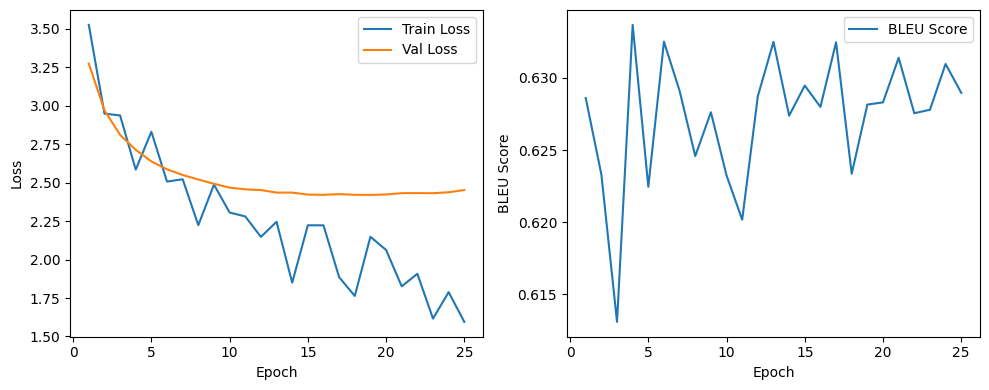

In [19]:
# Extract the metrics
epochs = list(epoch_metrics_dict.keys())
train_losses = [epoch_metrics_dict[epoch]["train_loss"] for epoch in epochs]
val_losses = [epoch_metrics_dict[epoch]["val_loss"] for epoch in epochs]
bleu_scores = [epoch_metrics_dict[epoch]["bleu_score"] for epoch in epochs]

# Plot the losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot the BLEU scores
plt.subplot(1, 2, 2)
plt.plot(epochs, bleu_scores, label="BLEU Score")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# generate caption
def get_caps_from(features_tensors):
    # generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
        caption = " ".join(caps)
    #         show_image(features_tensors[0], title=caption)

    return caps, alphas


def get_caps_from_show(features_tensors):
    # generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
        caption = " ".join(caps)
        show_image(features_tensors[0], title=caption)

    return caps, alphas

## Maximum Test **BLEU Score**


In [ ]:
max_bleu_score = 0
bleu_scores = []
for idx, (images, captions) in enumerate(iter(test_dataloader)):
    all_references = []
    all_hypotheses = []
    for caption in captions:
        all_references.append(reverse_process_caption(caption).split())
    for i in range(images.shape[0]):
        img = images[0].detach().clone()
        img1 = images[0].detach().clone()
        caps, alphas = get_caps_from(img.unsqueeze(0))
        all_hypotheses.append(caps)
    bleu_score = corpus_bleu(all_references, all_hypotheses)
    bleu_scores.append(bleu_score)

In [47]:
b = np.array(bleu_scores)
print(np.mean(bleu_scores))

0.6390451067328725


### Test Images


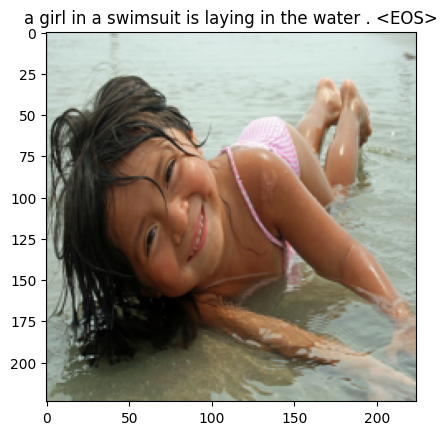

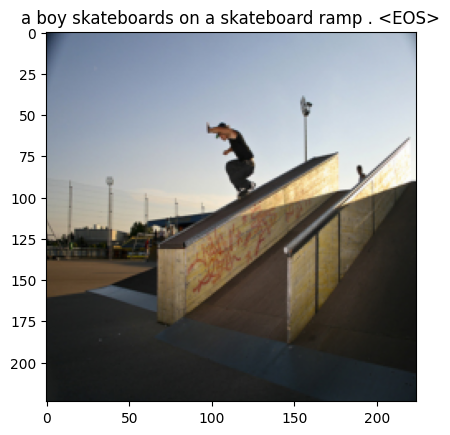

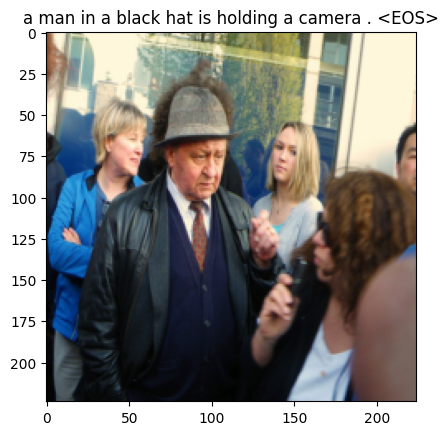

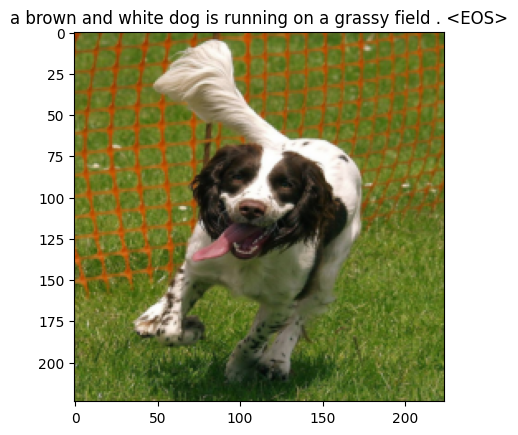

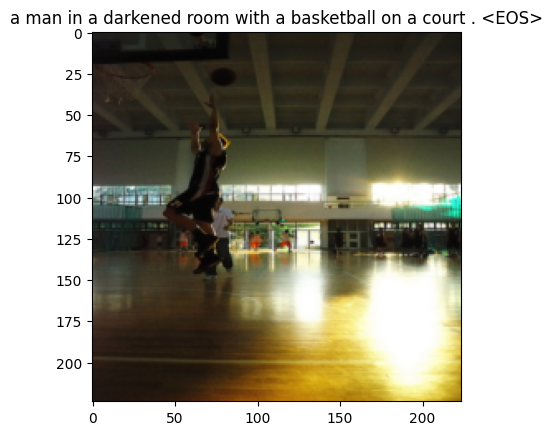

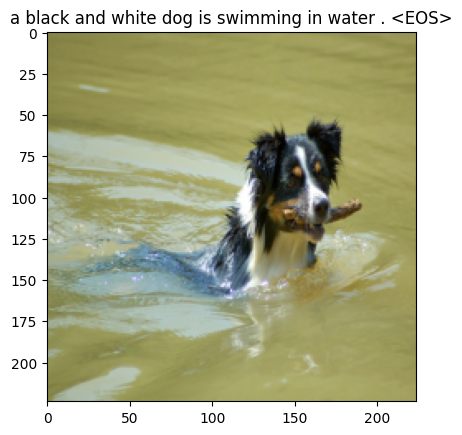

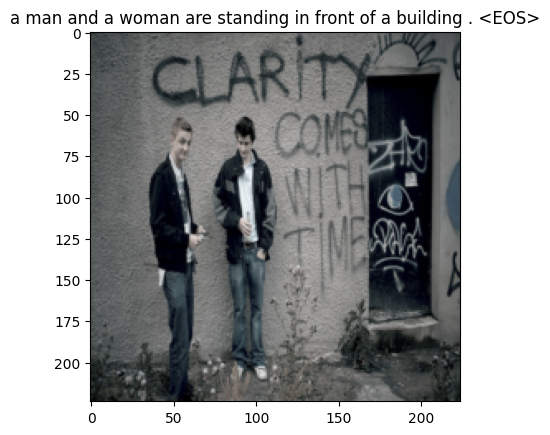

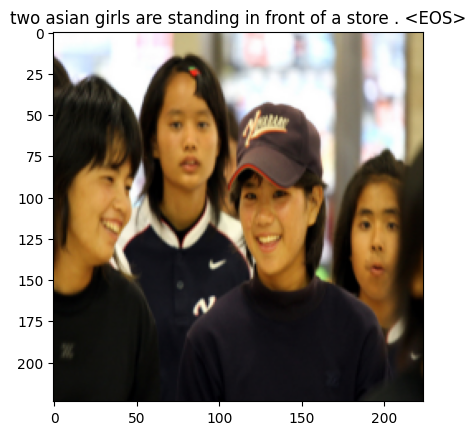

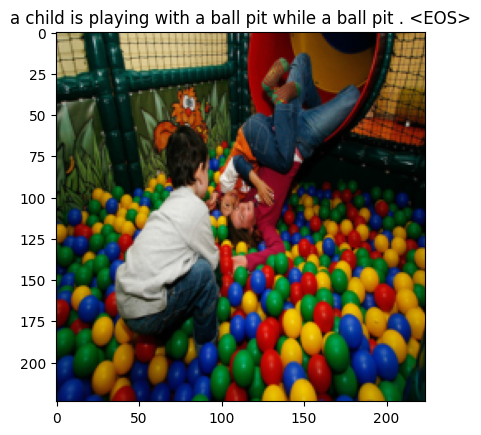

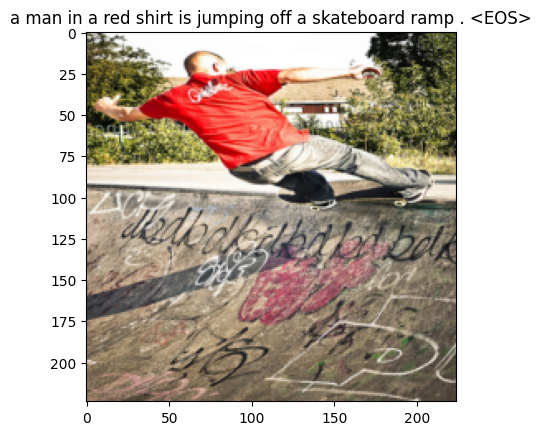

In [42]:
for i in range(20, 30):
    data_iter = iter(test_dataloader)
    images, caption = next(data_iter)
    img = images[i].detach().clone()
    caps, alphas = get_caps_from_show(img.unsqueeze(0))